# Deterministc Growth Model

This notebook solves the simplest macro model -- determinist growth model using value function iteration. 

## Thoery

Assume the economy starts with ininial captial ${k_t} > 0$ and that the labour supply is perfectly inelastic, each period $t = 0,1,2,...$ the representative household chooses the amount of consumption $c_t \geq 0$ and and investment $i_t \geq 0$ to maximize its lifetime utility 


$$
\max_{c_t}
    \left\{
    \sum_{t = 0}^{\infty} \beta^t u(c_t)
    \right\} \tag{1}
$$

where $\beta \in [0,1]$ is the discount factor. The representative household faces the budget constraint saying that consumption plus investment must not exceed income $y_t$. Assume that $u'(c)>0$, the budget constraint holds in equality, that is

$$
y_t = c_t + i_t. \tag{2}
$$

Define $\delta \in [0,1]$ be the depreciation rate. The law of motion of capital is therefore

$$
k_{t+1} = (1 - \delta) \cdot k_t + i_t. \tag{3}
$$

The income is solely determined the production function

$$
y_t = Af(k_t), \tag{4}
$$

where $A$ refer to the technology. Rearranging the above equations, the problems becomes

$$
\max_{c_t, k_{t+1}}
    \left\{
    \sum_{t = 0}^{\infty} \beta^t u(c_t)
    \right\} 
$$

$$
s.t.      c_t = (1 - \delta) \cdot k_t + Af(k_t) - k_{t+1},
$$

where $k_0$ is given. Further assume that $u''(c)<0$, by the concavity of the objective function and linearity of the constraint we can ensure that there exist a path {$c_t, k_{t+1}$} that solves the maximization problem.

Taking $k_{t+1} as the control variable, we can write the Bellman equation

$$
V(k) = \max_{k'}
    \left\{
    u[(1 - \delta) \cdot k + Af(k) - k'] + \beta V(k')
    \right\}.\tag{5}
$$

It can be easily found that the Euler Equation is 

$$ 
u'(c) = \beta \{u'(c')[Af'(k') + (1 - \delta)\} 
$$

which says that the marginal benefit of increasing consumption equals the marginal cost.

## Computation

In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon.optimize.scalar_maximization import brent_max
from interpolation import interp

We start by defining a class that specify parameters, utility and production functions compactly. We also need to specify the state space and the number of grids ```k_size``` so that we can perform grid search over the state space. Note that we have to ensure the state space is not binding.

In [18]:
class OptimalGrowth:

    def __init__(self,
                 f,                
                 u,                
                 β = 0.8,           
                 δ = 1,
                 A = 4,
                 max_k = 2,
                 k_size = 1000):
        
        self.β, self.δ, self.f, self.u = β, δ, f, u
        self.k_space = np.linspace(1e-5, max_k, k_size) # Discretize the state space
        self.max_k = max_k
        self.A = A

```operator``` contains the operators we need for this problem, with parameters, utility and production functions specified in ```og```, the class for parameters.

In [19]:
def operator(og):
    
    # Unpack the parameters that we specified in the class "OptimalGrowth"
    f, u, β, δ = og.f, og.u, og.β, og.δ
    k_space = og.k_space
    A = og.A

    # Objective Function -- LHS of the Bellman equation
    @jit
    def obj(new_k, v, old_k):
        val_func = lambda k: interp(k_space, v, k)  # intetpolate v -- the value function
        return u((1 - δ) * old_k + f(old_k) * A - new_k) + β * val_func(new_k)

    # Bellman Operator
    @jit 
    def Bellman(v):
        new_v = np.empty_like(v)
        for i in range(len(k_space)):
            old_k = k_space[i]
            max_v = brent_max(obj, 1e-10, (1 - δ) * old_k + f(old_k) * A, args = (v, old_k))[1]
            new_v[i] = max_v
        return new_v

    # Policy Function
    @jit
    def policy(v):
        p = np.empty_like(v)
        for i in range(len(k_space)):
            old_k = k_space[i]
            p_s = brent_max(obj, 1e-10, (1 - δ) * old_k + f(old_k) * A, args = (v, old_k))[0]
            p[i] = p_s
        return p
    
    # A function that can obtain the optimal paths of k, y, c. 
    def time_path(k,t):
        continuous_policy = lambda k: interp(k_space, true_p_func, k) 
        # "true_p_func" is the true policy function -- we need to define it using this exact name later so that the
        # function can run
        
        k_path = [k]
        y_path = [f(k) * A]
        c_path = []
        
        # Simulate k, y, c up to time t
        for i in range(t):
            new_k = continuous_policy(k)
            new_y = f(new_k) * A
            k_path.append(new_k)
            y_path.append(new_y)
            c_path.append((1 - δ) * k + f(k) * A - new_k)
            k = new_k
        
        return k_path, y_path, c_path

    return Bellman, policy, time_path

In this notebook, we take $f(k) = k^\alpha$, and $ u(c) = \dfrac {c^{1 - \gamma}}{1 - \gamma}$ for $\gamma \neq 1$ and $u(c) = log(c)$ for $\gamma = 1$.

In [20]:
α = 0.4
@jit
def f(k):
    return k**α

In [21]:
γ = 1
@jit
def u(c):
    if γ == 1:
        return np.log(c)
    else:
        return c**(1 - γ) / (1 - γ)

In [22]:
og = OptimalGrowth(f = f, u = u)
Bellman, policy, time_path = operator(og)

# This enables us to use functions "Bellman", "policy", "time_path" for the parameters and specific utility 
# and production functions we specified in the class "OptimalGrowth"

We now define a function ```iteration``` to iterate the value function until it converges or reaching the maxmimum iterations allowed. 

In [23]:
def iteration(og, tol = 1e-4, max_iter = 1000):

    Bellman, policy, time_path = operator(og)

    v = np.ones_like(og.k_space) # initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = Bellman(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    return v_new

We can obtain the true value function ```true_v_func``` by using the function ```iteration``` and plot it. 

In [24]:
true_v_func = iteration(og)

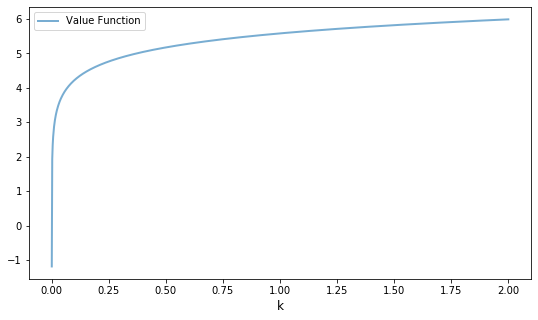

In [25]:
k_space = og.k_space
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(k_space, true_v_func, lw=2, alpha=0.6, label='Value Function')
plt.xlabel('k', size = 'large')

ax.legend()
plt.show()

We can use the operator ```policy``` for the true value function ```true_v_func``` to obtain the policy function.

In [26]:
true_p_func = policy(true_v_func)

We can calculate the steady state capital $k^*$ where $k^* = k_t = k_{t+1}$. Graphical analysis with the 45-degree line and policy function can veerify the answer.

In [27]:
diff = 1e-4
ss = None

for i,j in zip(k_space, true_p_func):
    if np.abs(i - j) < diff:
        diff = np.abs(i - j)
        ss = i
        
print("The steady-state capital is", ss)

The steady-state capital is 1.509511961961962


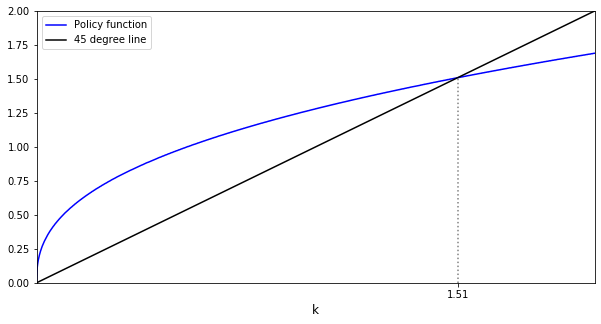

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(k_space, true_p_func, 'b', label='Policy function')
ax.plot(k_space,k_space, 'k',label = '45 degree line')

ax.set_xlim(0, og.max_k)
ax.set_ylim(0, og.max_k)

plt.axvline(ss, 0, ss/og.max_k, color = 'grey', linestyle =  ':')

plt.xticks([ss])

plt.xlabel('k', size = 'large')

ax.legend()
plt.show()

Finally, we obtain the optimal path of $c$, $y$, and $k$ by the function ```time_path``` with the initial condition $k_0$. It is observed the capital will remain at $k^*$, again verifying the analysis above.

In [29]:
k_0 = 0.1
max_time = 25
k_p, y_p, c_p = time_path(k_0,max_time)

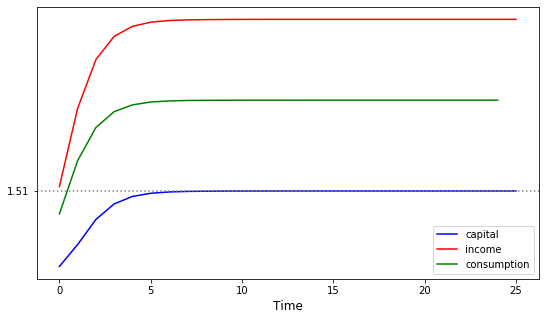

In [30]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(k_p,'b-', label='capital')
ax.plot(y_p, 'r-', label='income')
ax.plot(c_p, 'g-', label='consumption')
plt.xlabel('Time', size = 'large')
plt.yticks([ss])
plt.axhline(y = ss, color = 'grey', linestyle =  ':')

ax.legend()
plt.show()